<a href="https://colab.research.google.com/github/esemlak/esemlak/blob/main/reversi_csv_tensorflow_model_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -o /content/reversi_train.zip
!pip3 install keras-tuner

Archive:  /content/reversi_train.zip
  inflating: reversi_train.csv       
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
DATASET_PATH = "/content/reversi_train.csv"


# "r" for regression and "c" for classification
# for classification, the number of output nodes is automatically determined
TASK = "r"

# don't change the dummy batch size. There is a small bug in tensorflow.
# to get around that bug, dummy batch size is used
DUMMY_BATCH_SIZE = 5
BATCH_SIZE = 1000
EPOCHS = 100
TRAIN_FRAC = 0.8

CHECKPOINT_DIR = "/content/"

In [3]:
from collections import defaultdict
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import kerastuner as kt

import pandas as pd

import IPython

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


# This function will give us a fresh dataset object

In [4]:
def get_dataset(batch_size = 5):
    return tf.data.experimental.make_csv_dataset(
        DATASET_PATH,
        batch_size = batch_size,
        num_epochs = 1,
        field_delim= ',',
        header = True,
        label_name = "O0"
    )

# Creating the Model Inputs as a dictionary

In [5]:
model_inputs = {}

for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
    for col_name, col_values in batch.items():
        if (col_name[0:1] == 'I'):
          model_inputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=col_values.dtype)

In [6]:
model_inputs

{'I0': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I0')>,
 'I1': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I1')>,
 'I2': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I2')>,
 'I3': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I3')>,
 'I4': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I4')>,
 'I5': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I5')>,
 'I6': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I6')>,
 'I7': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I7')>,
 'I8': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I8')>,
 'I9': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I9')>,
 'I10': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I10')>,
 'I11': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I11')>,
 'I12': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I12')>,
 'I13': <KerasTenso

## split these inputs into their own dictionaries based on the data type

In [7]:
float_inputs = {}

for col_name, col_input in model_inputs.items():
    float_inputs[col_name] = col_input
    


In [8]:
float_inputs


{'I0': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I0')>,
 'I1': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I1')>,
 'I2': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I2')>,
 'I3': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I3')>,
 'I4': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I4')>,
 'I5': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I5')>,
 'I6': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I6')>,
 'I7': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I7')>,
 'I8': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I8')>,
 'I9': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I9')>,
 'I10': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I10')>,
 'I11': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I11')>,
 'I12': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'I12')>,
 'I13': <KerasTenso

In [9]:
def numerical_input_processor(inputs):
    if not inputs:
        return
    
    concat = None
    if len(inputs.values()) > 1:
        concat = tf.keras.layers.Concatenate()(list(inputs.values()))
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()

    #for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
    #    data = []
        
    #    for k in inputs.keys():
    #        data.append(np.array(batch[k]))    
        
    #    data = np.array(data)
    #    data = np.transpose(data)    

    #norm.adapt(data)

    # mean_log = []

    #for batch, _ in get_dataset(batch_size=BATCH_SIZE):
    #    data = []
        
    #    for k in inputs.keys():
    #        data.append(np.array(batch[k]))    
        
    #    data = np.array(data)
    #    data = np.transpose(data)

    #    norm.adapt(data)        
        # mean_log.append(norm.mean.numpy())    

    if concat is not None:
        numeric_layer = norm(concat)
    else:
        numeric_layer = norm(list(inputs.values())[0])
    
    return numeric_layer

## PreProcess the inputs

In [10]:
float_layer = numerical_input_processor(float_inputs)


In [11]:
float_layer

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'normalization')>

## Create a preprocessing keras model

In [12]:
preprocessing_head = tf.keras.Model(model_inputs, float_layer)

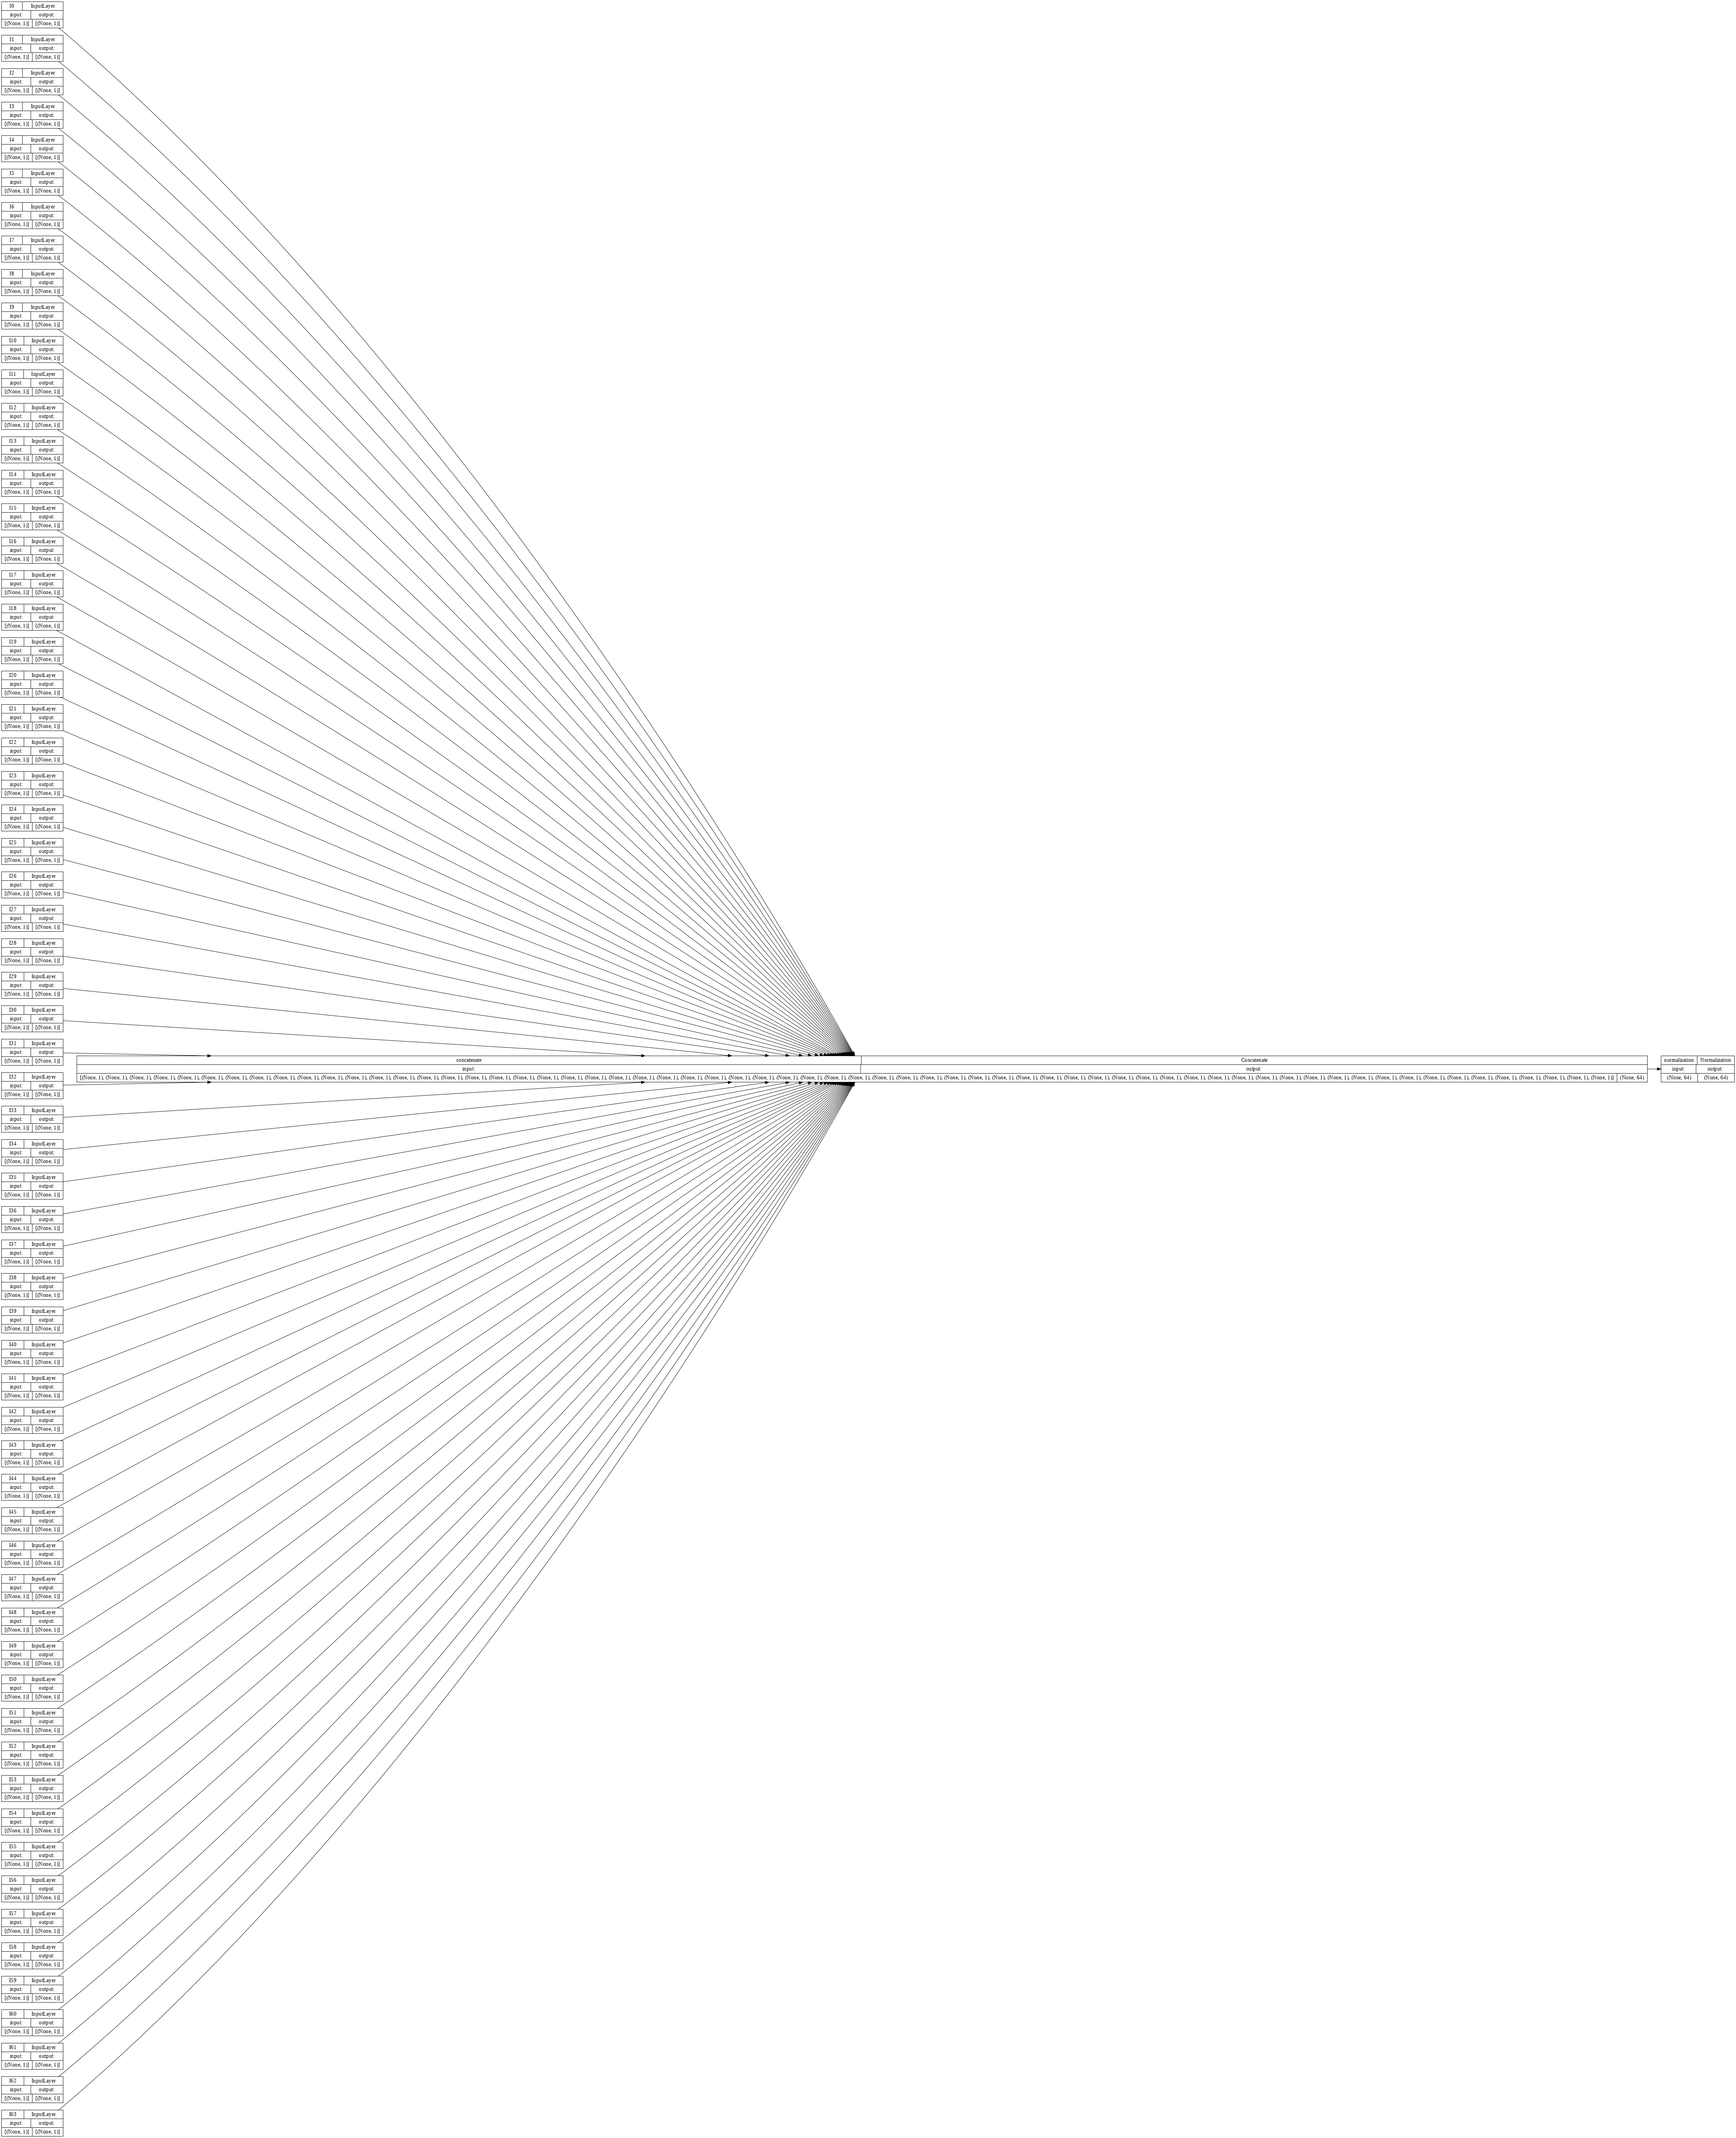

In [13]:
tf.keras.utils.plot_model(model = preprocessing_head, rankdir="LR", dpi=72, show_shapes=True, expand_nested=True, to_file="preprocessing_head.png")

## You can also see the preprocessed outputs for the given inputs

In [14]:
# preprocessing_head({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

# preprocessing_head({
#     "age" : np.array([22.0]),
#     "fare" : np.array([7.25]),
# })

## pass the model_inputs through the preprocessing_head

In [15]:
preprocessed_outputs = preprocessing_head(model_inputs)

In [16]:
num_preprocessed_outputs = list(preprocessed_outputs.shape)[-1]

In [17]:
num_preprocessed_outputs

64

## Find out how many batches should be used for training and how many for validation

In [18]:
dataset_size = 0

for _ in get_dataset(batch_size=BATCH_SIZE):
    dataset_size += 1

In [19]:
train_size = int(TRAIN_FRAC * dataset_size)

In [20]:
print(dataset_size)
print(train_size)

426
340


## Split the training and validation datasets


In [21]:
dataset = get_dataset(batch_size=BATCH_SIZE)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Set a caching mechanism that prefetches the next batch while the current batch is training

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## define early stopping and checkpointing callbacks

In [23]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, "M.{epoch:02d}-{loss:.2f}"))

In [24]:
callbacks = [
    early_stopping_callback,
    checkpoint_callback,
]

In [25]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

## model builder function is used by keras-tuner to find the best parameters for a model

In [26]:
def model_builder(hp):
    loss_fn = 'mse'

    metrics= tf.keras.metrics.RootMeanSquaredError()
 
    kernel_hp = hp.Choice('kernel_regularization', values = [0.01, 0.001, 0.0001, 0.00001])
    activation_hp = hp.Choice("activation", values=["elu", "relu"])
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=train_size*1000,
        decay_rate=1,
        staircase=False
    )


    input_layer = tf.keras.layers.Input(shape=64)

    first_dense = tf.keras.layers.Dense(units='64', activation='relu')(preprocessed_outputs )
    
    #XV output will be fed from the first dense
    moves_output = tf.keras.layers.Dense(units='64', name='MOVES')(first_dense)
    
    
    
    model = tf.keras.Model(model_inputs, outputs = [moves_output])
    
    model.compile(loss=loss_fn, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                  metrics=metrics
    )
  
    return model



## initialize keras tuner

In [27]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_dir',
                     project_name = 'tuner')

In [28]:
tuner.search(
    train_dataset, 
    validation_data=val_dataset,
    epochs=10,
    callbacks = [ClearTrainingOutput()]
)

Trial 8 Complete [00h 00m 09s]
val_loss: 2.2878751670951658e-10

Best val_loss So Far: 3.090203099604971e-33
Total elapsed time: 00h 02m 23s


In [29]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## These are the best model parameters

In [30]:
best_hps.values

{'kernel_regularization': 1e-05,
 'activation': 'elu',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [31]:
model = tuner.hypermodel.build(best_hps)

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 I0 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 I1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 I10 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 I11 (InputLayer)               [(None, 1)]          0           []                               
                                                                                            

In [33]:
tf.keras.utils.plot_model(model = model, rankdir="LR", dpi=96, show_shapes=True, expand_nested=True, to_file="model.png")

## Find out training and validation losses with untrained model

In [34]:
# loss with un-trained model
model.evaluate(train_dataset)

340/340 [==============================] - 3s 7ms/step - loss: 1.6660 - root_mean_squared_error: 1.2908


[1.6660387516021729, 1.2907512187957764]

In [35]:
# val_loss with un-trained model
model.evaluate(val_dataset)

86/86 [==============================] - 1s 7ms/step - loss: 1.6280 - root_mean_squared_error: 1.2759


[1.6279776096343994, 1.275922179222107]

## Train the model

In [ ]:
train_set = pd.read_csv(DATASET_PATH, delimiter = ',')
train_set.head()

history = model.fit(
    [
    train_set['I0'],train_set['I1'],train_set['I2'],train_set['I3'],train_set['I4'],train_set['I5'],train_set['I6'],train_set['I7'],train_set['I8'],train_set['I9'],
    train_set['I10'],train_set['I11'],train_set['I12'],train_set['I13'],train_set['I14'],train_set['I15'],train_set['I16'],train_set['I17'],train_set['I18'],train_set['I19'],
    train_set['I20'],train_set['I21'],train_set['I22'],train_set['I23'],train_set['I24'],train_set['I25'],train_set['I26'],train_set['I27'],train_set['I28'],train_set['I29'],
    train_set['I30'],train_set['I31'],train_set['I32'],train_set['I33'],train_set['I34'],train_set['I35'],train_set['I36'],train_set['I37'],train_set['I38'],train_set['I39'],
    train_set['I40'],train_set['I41'],train_set['I42'],train_set['I43'],train_set['I44'],train_set['I45'],train_set['I46'],train_set['I47'],train_set['I48'],train_set['I49'],
    train_set['I50'],train_set['I51'],train_set['I52'],train_set['I53'],train_set['I54'],train_set['I55'],train_set['I56'],train_set['I57'],train_set['I58'],train_set['I59'],
    train_set['I60'],train_set['I61'],train_set['I62'],train_set['I63']
    ], 
    [
    train_set['O0'],train_set['O1'],train_set['O2'],train_set['O3'],train_set['O4'],train_set['O5'],train_set['O6'],train_set['O7'],train_set['O8'],train_set['O9'],
    train_set['O10'],train_set['O11'],train_set['O12'],train_set['O13'],train_set['O14'],train_set['O15'],train_set['O16'],train_set['O17'],train_set['O18'],train_set['O19'],
    train_set['O20'],train_set['O21'],train_set['O22'],train_set['O23'],train_set['O24'],train_set['O25'],train_set['O26'],train_set['O27'],train_set['O28'],train_set['O29'],
    train_set['O30'],train_set['O31'],train_set['O32'],train_set['O33'],train_set['O34'],train_set['O35'],train_set['O36'],train_set['O37'],train_set['O38'],train_set['O39'],
    train_set['O40'],train_set['O41'],train_set['O42'],train_set['O43'],train_set['O44'],train_set['O45'],train_set['O46'],train_set['O47'],train_set['O48'],train_set['O49'],
    train_set['O50'],train_set['O51'],train_set['O52'],train_set['O53'],train_set['O54'],train_set['O55'],train_set['O56'],train_set['O57'],train_set['O58'],train_set['O59'],
    train_set['O60'],train_set['O61'],train_set['O62'],train_set['O63']
    ], 
    callbacks=callbacks,
    epochs=EPOCHS)

Epoch 1/100
13300/13301 [============================>.] - ETA: 0s - loss: 2.0042e-04 - root_mean_squared_error: 0.0142

13301/13301 [==============================] - 113s 8ms/step - loss: 2.0042e-04 - root_mean_squared_error: 0.0142
Epoch 2/100
13296/13301 [============================>.] - ETA: 0s - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00

13301/13301 [==============================] - 113s 8ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Epoch 3/100
 1729/13301 [==>...........................] - ETA: 1:35 - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00

## Find out training and validation losses with trained model

In [ ]:
# loss with trained model
model.evaluate(train_dataset)

In [ ]:
# val_loss with trained model
model.evaluate(val_dataset)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

In [ ]:
if TASK == "c":
    plot_acc(history)

## Test the model on some dummy data

In [ ]:
# model.predict({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

In [ ]:
# reloaded = tf.keras.models.load_model("models/titanic_model.24-1610.52")

In [ ]:
# reloaded.evaluate(train_dataset)

In [ ]:
# reloaded.evaluate(val_dataset)